In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
import os

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPool2D
from keras.optimizers import Adam, RMSprop

In [3]:
%pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [4]:
import shutil
shutil.rmtree("/kaggle/working/Kentang-data")

In [6]:
# Split train test 
import splitfolders 
splitfolders.ratio("/kaggle/input/agronify-dataset/DiseasedPlants/Perkebunan/Kentang", output="Kentang-data", seed=1337, ratio=(.8, .1,.1), group_prefix=None) 

Copying files: 2341 files [00:26, 87.79 files/s] 


In [7]:
training_dir = os.path.join('Kentang-data', 'train')
testing_dir = os.path.join('Kentang-data', 'test')
validating_dir = os.path.join('Kentang-data', 'val')

In [9]:
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	training_dir,
    shuffle=True,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
	validating_dir,
	target_size=(224,224),
    shuffle=True,
	class_mode='categorical',
  batch_size=32
)

testing_generator = validation_datagen.flow_from_directory(
    testing_dir,
    target_size=(224, 224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32
)


Found 1871 images belonging to 3 classes.
Found 233 images belonging to 3 classes.
Found 237 images belonging to 3 classes.


In [23]:
class_indices = train_generator.class_indices
print(class_indices)
class_names = list(class_indices.keys())
print(class_names)

{'Potato__early_blight': 0, 'Potato__healthy': 1, 'Potato__late_blight': 2}
['Potato__early_blight', 'Potato__healthy', 'Potato__late_blight']


In [33]:
def display_images(images, labels, class_indices):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        label_index = np.argmax(labels[i])
        label = list(class_indices.keys())[list(class_indices.values()).index(label_index)]
        ax.set_title(label)
        plt.subplots_adjust(wspace=1)
        ax.axis('off')


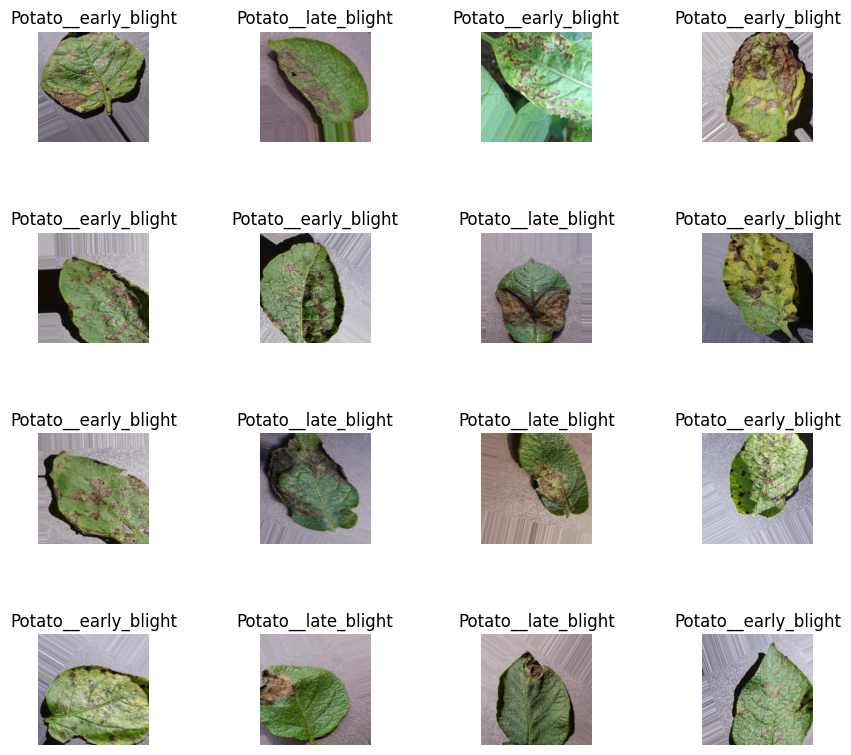

In [34]:
train_images, train_labels = next(train_generator)
display_images(train_images, train_labels, train_generator.class_indices)
plt.show()

In [15]:
# Define Callback
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy')>=0.98):   
            keys = list(logs.keys())
            print("End epoch {} of training; got log keys: {}".format(epoch, keys))
            self.model.stop_training = True
            
# define object from CustomCallback Class
callbacks = CustomCallback()

In [17]:
def generator_to_dataset(generator):
    output_types = (tf.float32, tf.float32)
    output_shapes = (tf.TensorShape([None, 224, 224, 3]), tf.TensorShape([None, generator.num_classes]))

    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=output_types,
        output_shapes=output_shapes
    )

    return dataset


In [18]:
train_dataset = generator_to_dataset(train_generator)
validation_dataset = generator_to_dataset(validation_generator)
testing_dataset = generator_to_dataset(testing_generator)


In [19]:
buffer_size = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=buffer_size)
validation_dataset = validation_dataset.prefetch(buffer_size=buffer_size)
testing_dataset = testing_dataset.prefetch(buffer_size=buffer_size)

In [37]:

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 26, 26, 64)      

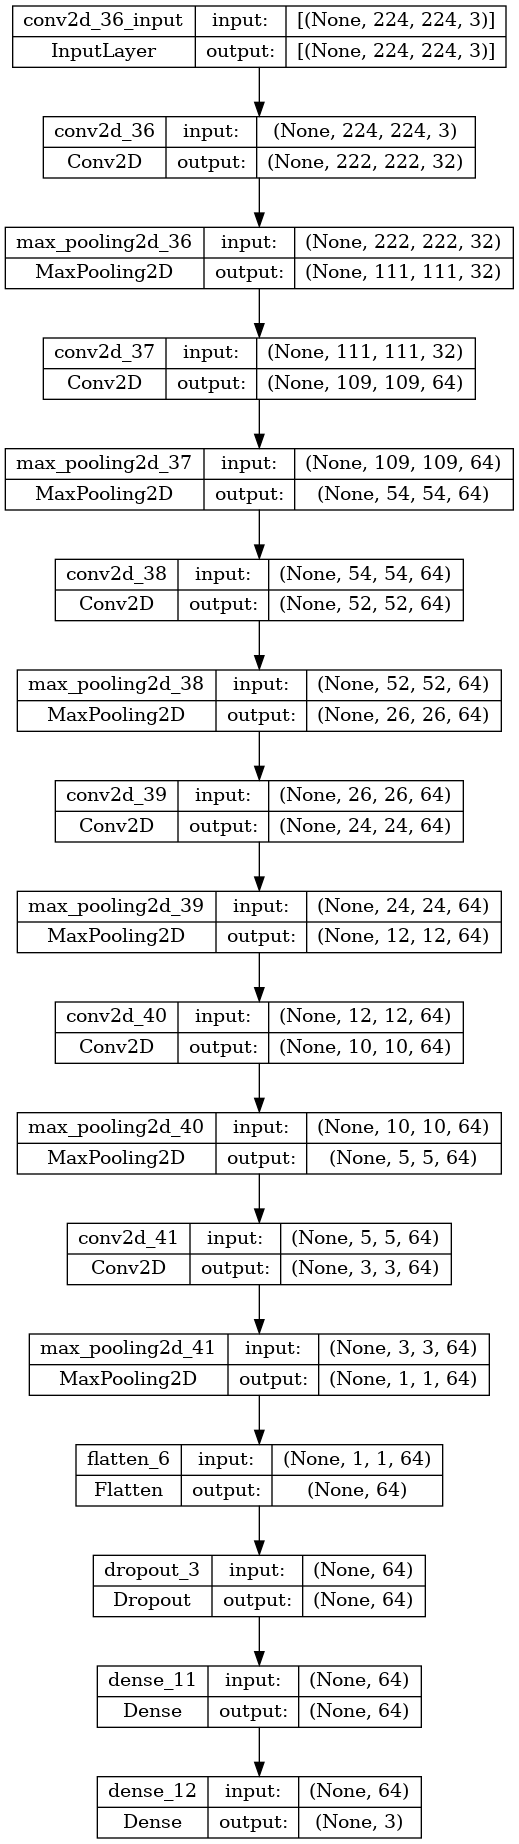

In [38]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [39]:
model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [40]:
history = model.fit(train_generator, 
                    epochs=100,
                    validation_data = validation_generator, 
                    verbose = 1, 
                    batch_size=32,
                    callbacks=[CustomCallback()], 
                    validation_steps=3)

Epoch 1/100
59/59 [==============================] - 32s 487ms/step - loss: 0.9017 - accuracy: 0.4869 - val_loss: 0.8723 - val_accuracy: 0.4479
Epoch 2/100
59/59 [==============================] - 29s 483ms/step - loss: 0.8092 - accuracy: 0.5772 - val_loss: 0.6082 - val_accuracy: 0.6875
Epoch 3/100
59/59 [==============================] - 29s 493ms/step - loss: 0.6928 - accuracy: 0.7028 - val_loss: 0.6139 - val_accuracy: 0.7708
Epoch 4/100
59/59 [==============================] - 28s 475ms/step - loss: 0.5912 - accuracy: 0.7531 - val_loss: 0.7842 - val_accuracy: 0.6667
Epoch 5/100
59/59 [==============================] - 29s 483ms/step - loss: 0.4950 - accuracy: 0.7905 - val_loss: 0.3733 - val_accuracy: 0.8438
Epoch 6/100
59/59 [==============================] - 28s 471ms/step - loss: 0.4705 - accuracy: 0.8065 - val_loss: 0.6341 - val_accuracy: 0.7292
Epoch 7/100
59/59 [==============================] - 30s 495ms/step - loss: 0.3983 - accuracy: 0.8348 - val_loss: 0.3481 - val_accuracy:

In [41]:
score = model.evaluate(testing_generator, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

8/8 [==============================] - 1s 146ms/step - loss: 0.1608 - accuracy: 0.9198
Test loss: 0.1608312875032425 / Test accuracy: 0.9198312163352966


In [44]:
predictions = model.predict(testing_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = testing_generator.classes
class_labels = list(testing_generator.class_indices.keys())

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(true_classes, predicted_classes, target_names=class_labels))
print(confusion_matrix(true_classes, predicted_classes))


8/8 [==============================] - 1s 73ms/step
                      precision    recall  f1-score   support

Potato__early_blight       0.52      0.53      0.52       111
     Potato__healthy       0.00      0.00      0.00        16
 Potato__late_blight       0.51      0.49      0.50       110

            accuracy                           0.48       237
           macro avg       0.34      0.34      0.34       237
        weighted avg       0.48      0.48      0.48       237

[[59  9 43]
 [ 8  0  8]
 [47  9 54]]


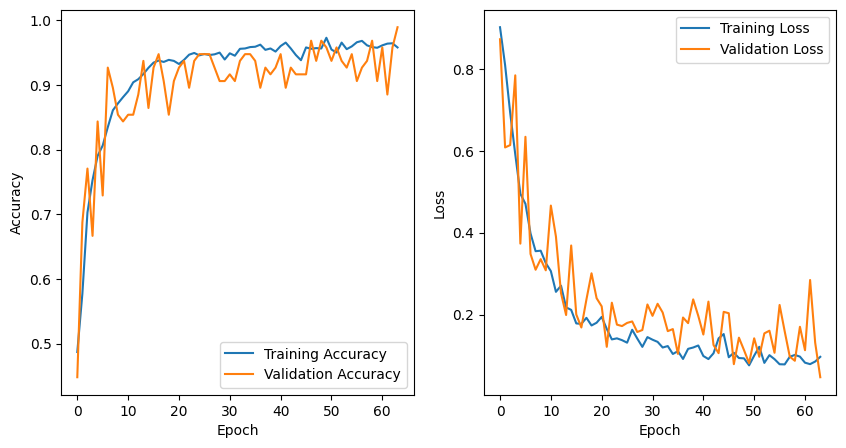

In [47]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


1/1 [==============================] - 0s 32ms/step


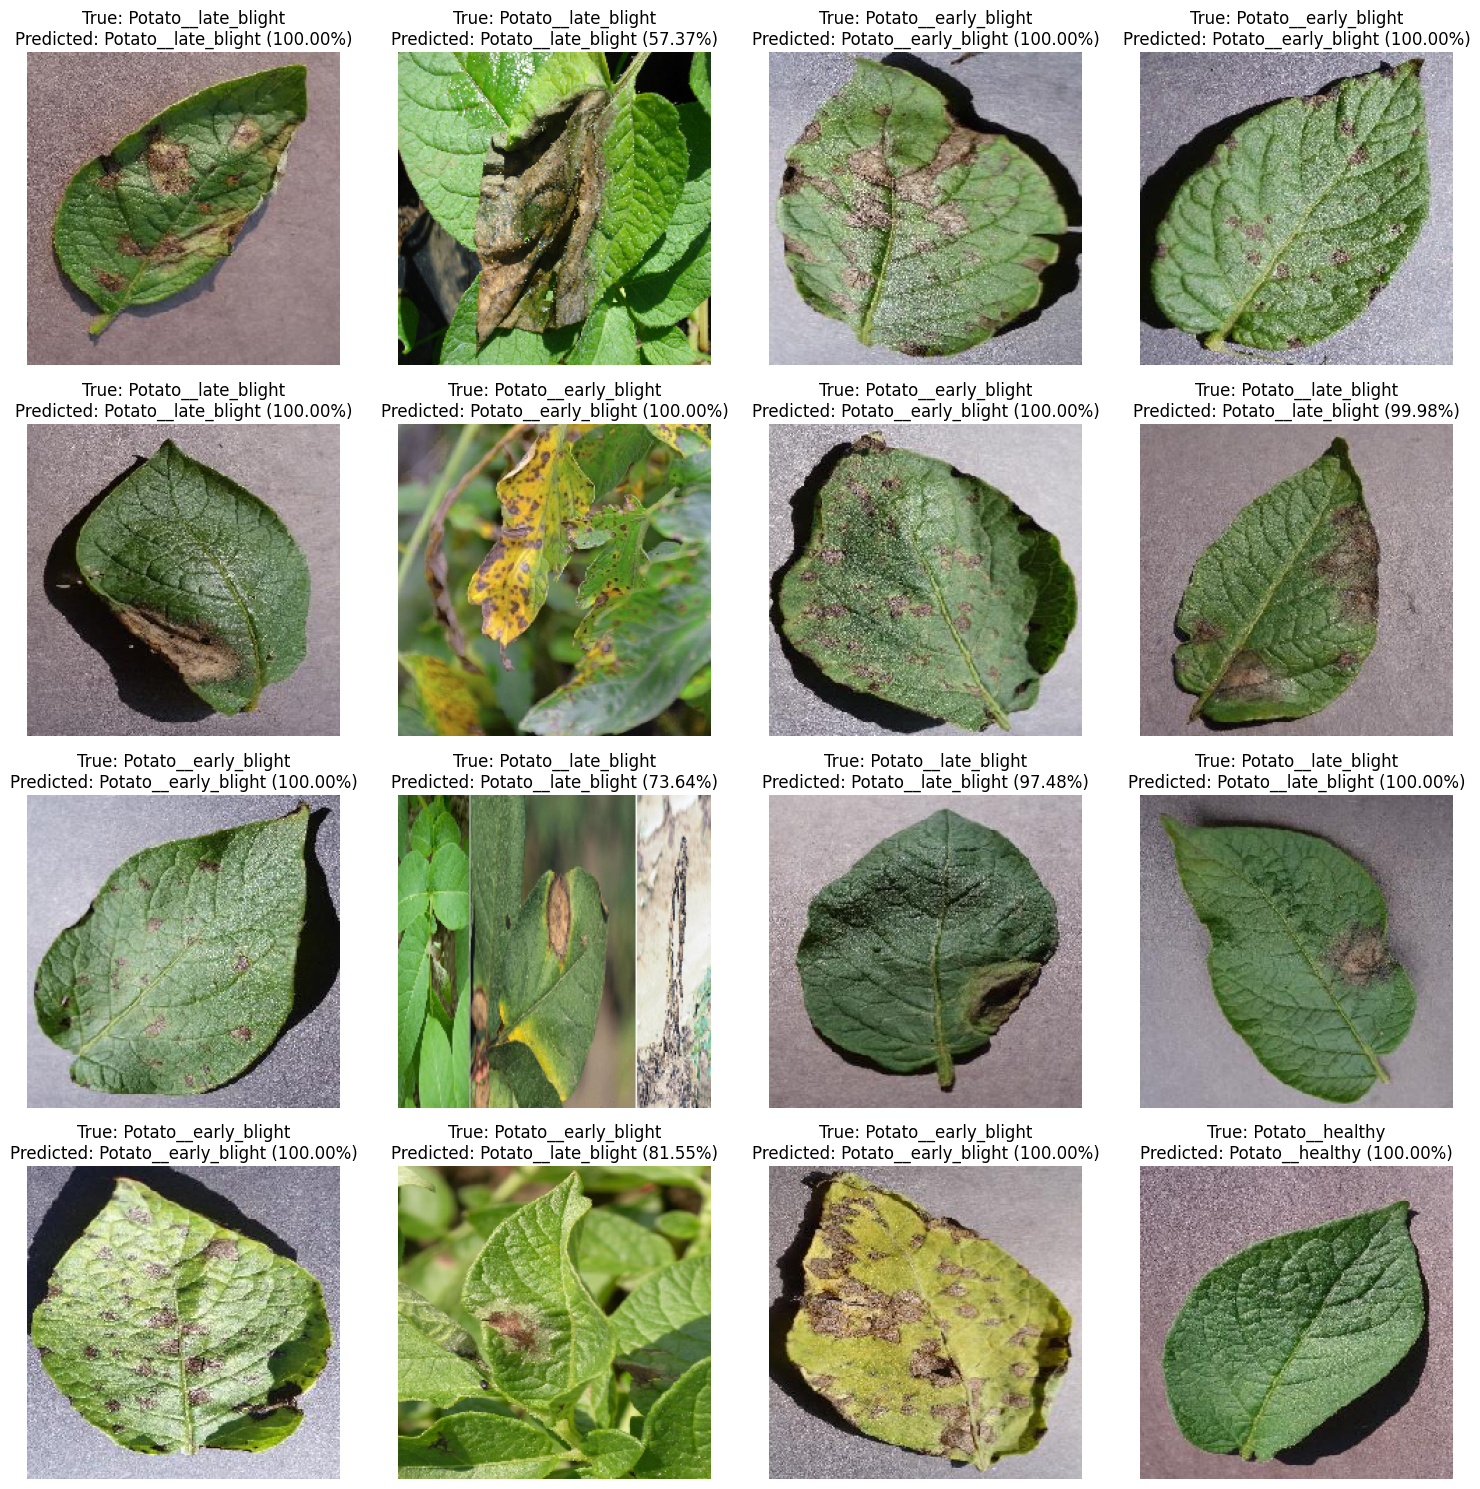

In [50]:
def plot_images(images, true_labels, predicted_labels, predicted_probs):
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(f"True: {true_labels[i]}\nPredicted: {predicted_labels[i]} ({predicted_probs[i]:.2%})")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

images, labels = next(iter(testing_generator))
predicted_probs = model.predict(images)
predicted_labels = [class_labels[i] for i in np.argmax(predicted_probs, axis=1)]
true_labels = [class_labels[i] for i in np.argmax(labels, axis=1)]
predicted_probs = np.max(predicted_probs, axis=1)

plot_images(images, true_labels, predicted_labels, predicted_probs)


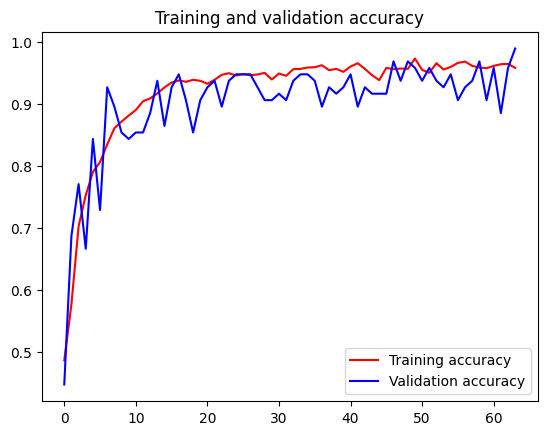

<Figure size 640x480 with 0 Axes>

In [51]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()